In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from urllib2 import urlopen
import matplotlib.pyplot as plt
import unicodedata
import requests
import re

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [5]:
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics

# Intro: Ridge and Lasso regression

Working from the preliminary notebook np_workingFit.ipynb, this notebook extends the Linear Regression fit adding shrinkage to the regression parameters to attempt to get a better explanory model 

In [6]:
df = pd.read_csv('dat_engRATE.csv')

In [7]:
df_smaller = df.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'Pages', 'Metascore',
                          'Year', 'imdbRating', 'tomatoRating','tomatoU' ]]

In [8]:
df_smaller[:3]

,Rating,Rating_Count,w_Rating,logRating_Count,Pages,Metascore,Year,imdbRating,tomatoRating,tomatoU
0,4.11,169979,3.27,5.23,297,86,1968,8.3,9.1,3.8
1,3.95,7455,2.33,3.87,448,42,2002,6.2,4.1,3.1
2,3.79,109745,2.91,5.04,307,75,2002,7.1,7.7,2.8


### POLYNOMIAL of values

In [10]:
df_smaller['sqrRating'] = np.square(df_smaller.Rating)
df_smaller['sqrw_Rating'] = np.square(df_smaller.w_Rating)
df_smaller['cube_Rating'] = df_smaller.Rating**3

df_smaller[:3]

,Rating,Rating_Count,w_Rating,logRating_Count,Pages,Metascore,Year,imdbRating,tomatoRating,tomatoU,sqrRating,sqrw_Rating,cube_Rating
0,4.11,169979,3.27,5.23,297,86,1968,8.3,9.1,3.8,16.8921,10.6929,69.426531
1,3.95,7455,2.33,3.87,448,42,2002,6.2,4.1,3.1,15.6025,5.4289,61.629875
2,3.79,109745,2.91,5.04,307,75,2002,7.1,7.7,2.8,14.3641,8.4681,54.439939


In [9]:
responses = ['imdbRating', 'tomatoRating','tomatoU','Metascore']
predictor = ['w_Rating','Rating']

In [11]:
re_name = responses[0]
pred_name = ['Rating', 'Rating_Count','w_Rating' ,'logRating_Count',
             'sqrRating','sqrw_Rating', 'Pages', 'Year']#,'cube_Rating']

selected_columns = pred_name
y = df_smaller[re_name]

print(re_name, '\t',pred_name)

imdbRating 	 ['Rating', 'Rating_Count', 'w_Rating', 'logRating_Count', 'sqrRating', 'sqrw_Rating', 'Pages', 'Year']


In [12]:
X=df_smaller.loc[:,selected_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [14]:
lr_model_3 = LinearRegression()
lr_model_3.fit(X_train,y_train)
test_pred_3 = lr_model_3.predict(X_test)
list(zip(X_train.columns,lr_model_3.coef_)) 


[('Rating', -6.1020730288910716),
 ('Rating_Count', 3.2197555953548408e-08),
 ('w_Rating', 1.5510991627793751),
 ('logRating_Count', -0.98588839144281615),
 ('sqrRating', 0.8331308183327738),
 ('sqrw_Rating', -0.003778654862603037),
 ('Pages', -0.00041127573990666438),
 ('Year', -0.027925939534384381)]

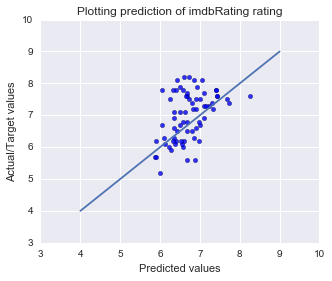

In [16]:
plt.figure(figsize=(5,4))
plt.scatter( test_pred_3, y_test, alpha=0.8)
plt.plot(np.linspace(4,9), np.linspace(4,9))

plt.title('Plotting prediction of {} rating'.format(re_name))
plt.ylabel('Actual/Target values');plt.xlabel('Predicted values');

In [17]:
#RMSE
print ("RMSE ", np.sqrt(np.mean((test_pred_3 - y_test)**2)))
#MAD
print ("MAD" ,(np.mean(np.abs(test_pred_3 - y_test))))
print (metrics.r2_score(y_test,test_pred_3))

RMSE  0.73300336816
MAD 0.570188908685
0.0556919469813


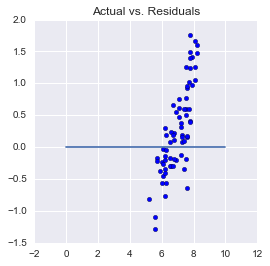

In [18]:
# Plot Residuals
plt.figure(figsize=(4,4))
lin_reg_residuals = y_test - test_pred_3
plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

 **tomatoRating (R-2 = 0.088)** does somewhat better  than  imdbRating (R-2 = 0.05569)  Metascore (R-2 = 0.03587 ) and TomatoU (R-2 = 0.0001834). However the model still seems to lack some explanatory power. 


# Ridge and Lasso Regression Models 

It's time to introduce some shrinkage of the regression coefficients through Ridge and Lasso Reression Model aids

In [19]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
